## Imports

In [1]:
from glob import glob
import json
import numpy as np
import pandas as pd
import PIL

from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
sns.set_style("dark", {'axes.grid' : False})
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Load & display app screenshot images

In [2]:
app_imgs = glob('app_uis/*.jpg')
print('Total app screenshot images: {0:,}'.format(len(app_imgs)))

Total app screenshot images: 72,219


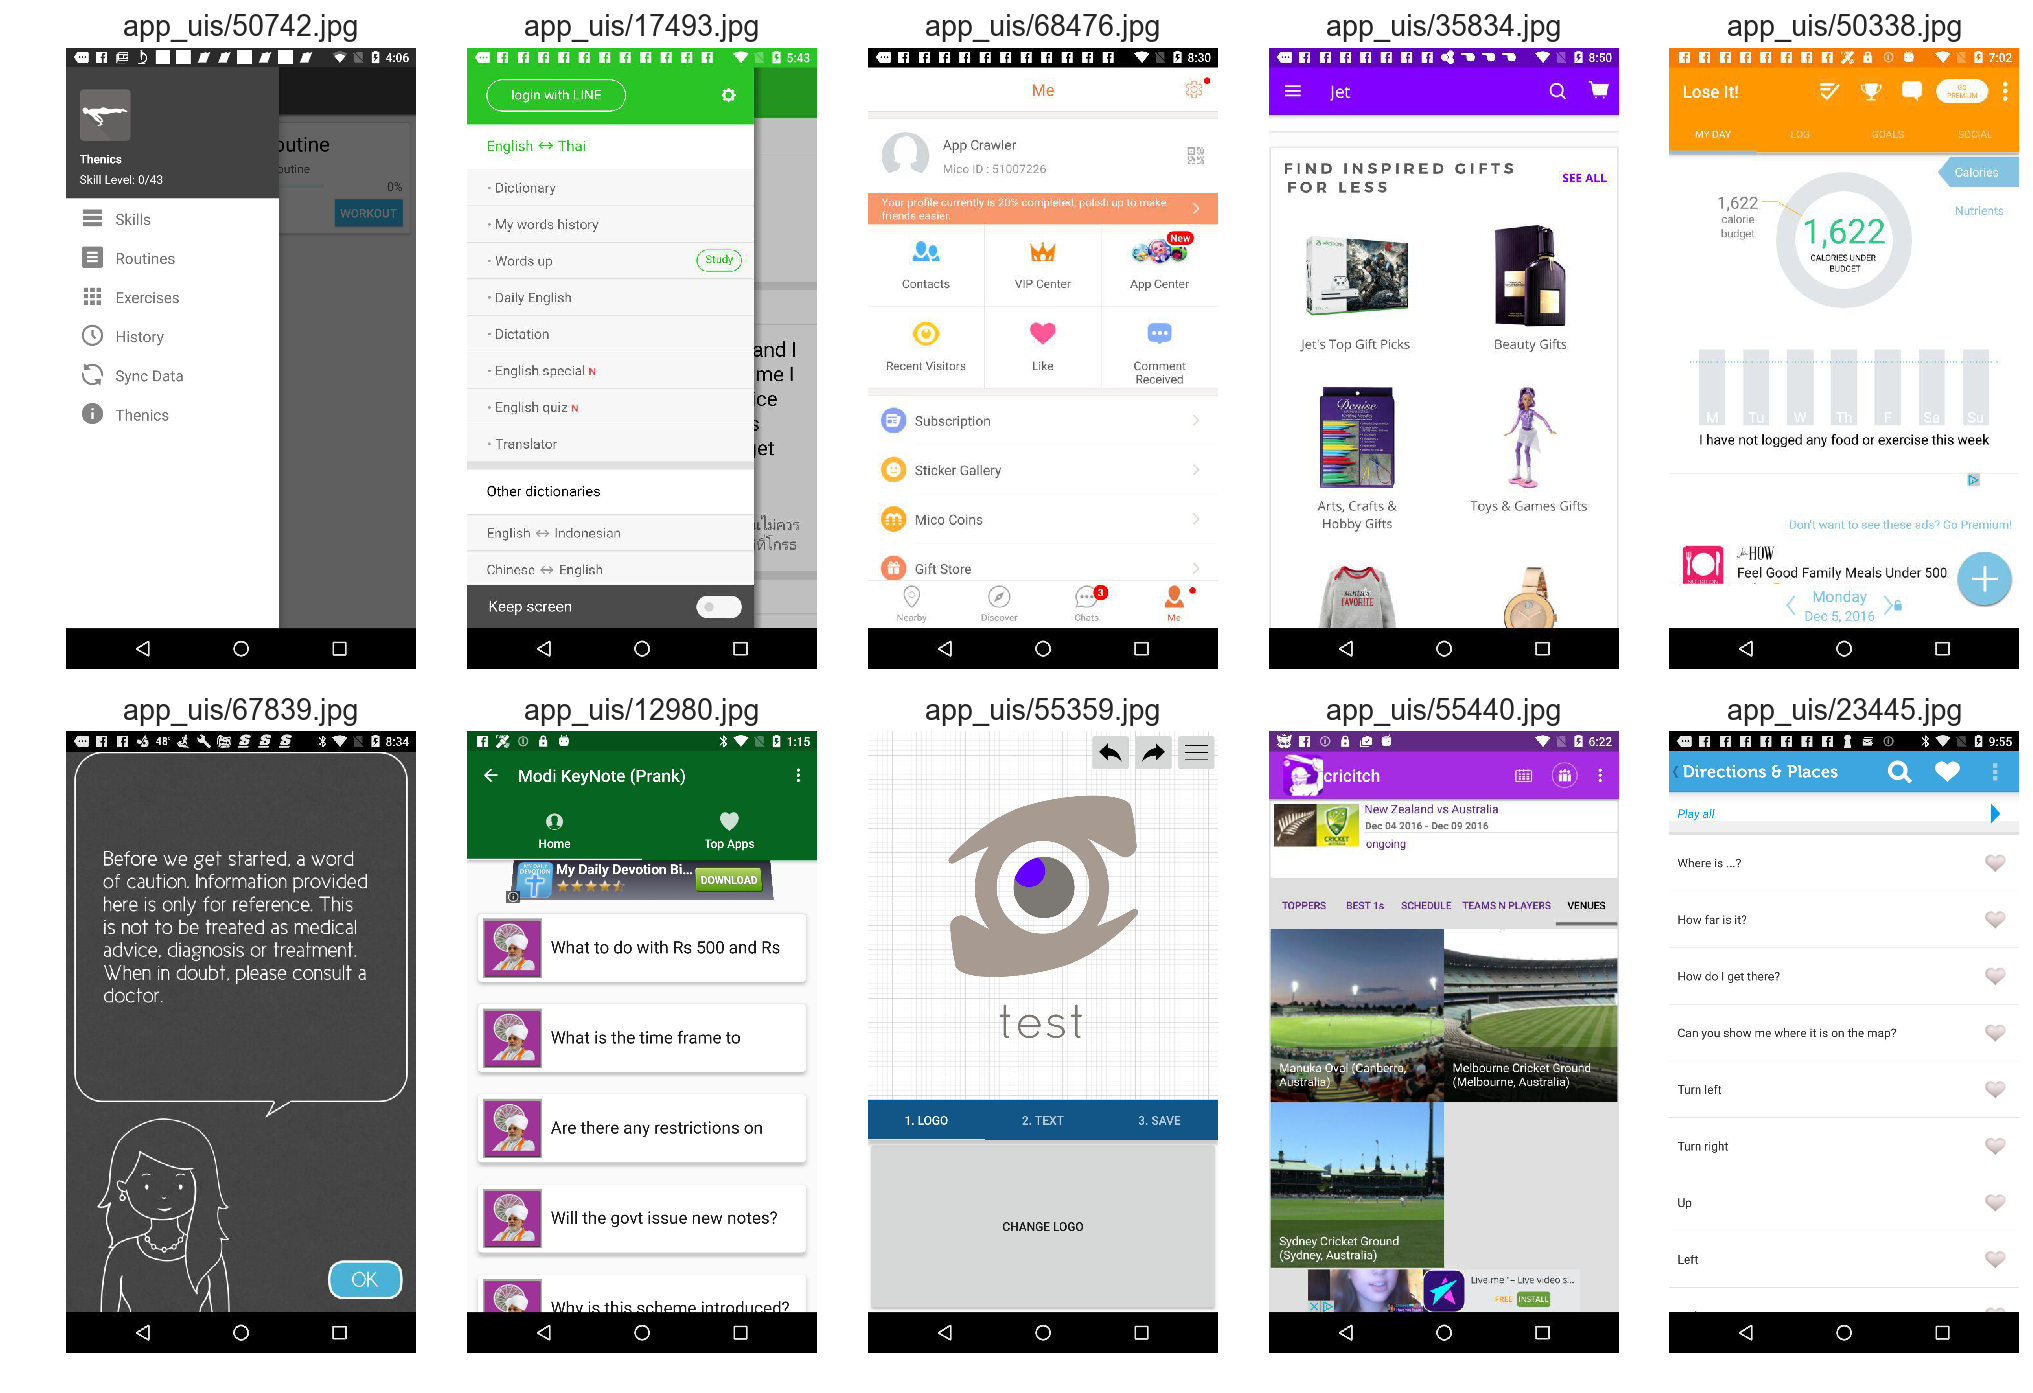

In [3]:
plt.rcParams['figure.figsize'] = (16.0, 12.0)
plt.subplots_adjust(wspace=0, hspace=.1)

for i, f in enumerate(np.random.choice(app_imgs, 10)):
    img = PIL.Image.open(f)
    plt.subplot(2, 5, i + 1) 
    plt.imshow(img)
    plt.title(f)
    plt.axis('off');  

## App view hierarchy
This is essentially the structure of the app's UI based on the android code. For the purposes of this project, it does not provide any additional information.

In [4]:
with open('app_uis/0.json', 'r') as f:
    app_img_data = json.load(f)

print(app_img_data.keys())
print()
print(app_img_data['activity']['root'].keys())

dict_keys(['activity_name', 'activity', 'is_keyboard_deployed', 'request_id'])

dict_keys(['scrollable-horizontal', 'draw', 'ancestors', 'clickable', 'pressed', 'focusable', 'long-clickable', 'enabled', 'bounds', 'visibility', 'content-desc', 'rel-bounds', 'focused', 'selected', 'scrollable-vertical', 'children', 'adapter-view', 'abs-pos', 'pointer', 'class', 'visible-to-user'])


## UI details
Metadata about each UI screen.

In [5]:
ui_details = pd.read_csv('raw_data/ui_details.csv')
ui_details.columns = [c.lower().replace(' ', '_') for c in ui_details.columns]
ui_details['filename'] = ui_details['ui_number'].map(lambda x: 'app_uis/' + str(x) + '.jpg')
ui_details.head()

,ui_number,app_package_name,interaction_trace_number,ui_number_in_trace,filename
0,0,com.brc.PeriodTrackerDiary,0,15,app_uis/0.jpg
1,1,com.brc.PeriodTrackerDiary,0,531,app_uis/1.jpg
2,2,yong.app.videoeditor,0,221,app_uis/2.jpg
3,3,yong.app.videoeditor,0,1289,app_uis/3.jpg
4,4,yong.app.videoeditor,0,125,app_uis/4.jpg


In [6]:
print('Shape: {0}'.format(ui_details.shape))
print('Total app screenshot images: {0:,}'.format(len(ui_details.ui_number.value_counts())))
print('Length of ui_number equals length app_imgs: {0}'.format(len(ui_details.ui_number.value_counts()) == len(app_imgs)))
print('Unique app packages: {0:,}'.format(len(ui_details.app_package_name.value_counts())))

Shape: (72219, 5)
Total app screenshot images: 72,219
Length of ui_number equals length app_imgs: True
Unique app packages: 9,772


#### App package frequency
Repeat app package names exist as the data include screenshots of different states within the same app.

In [7]:
ui_details.app_package_name.value_counts().head(10)

com.lazada.android                    76
com.fourtechnologies.mynetdiary.ad    73
com.jet.jet.app                       72
com.slacker.radio                     70
com.fivemobile.thescore               70
com.bigoven.android                   69
com.talabat                           65
com.jackthreads.android               64
com.bravolang.spanish                 63
com.mapmywalk.android2                62
Name: app_package_name, dtype: int64

#### Interaction traces
Each app has interaction traces which are comprised of a sequence of UIs captured as screenshots (essentially the flow of states a user experiences while using an app). Each app can have multiple traces, ie trace_0, trace_1, etc. For the purpose of this project, this data will be ignored. 

In [8]:
ui_details.interaction_trace_number.value_counts()

0    62188
1     7520
2     2317
3      166
4       23
6        5
Name: interaction_trace_number, dtype: int64

**`ui_number_in_trace`** refers to the given screenshot's particular order in any given interaction trace. For the purpose of this project, this data will be ignored. 

In [9]:
len(ui_details.ui_number_in_trace.value_counts())

5533

####  Remove images that can't be opened with PIL

In [10]:
def img_validator(images):
    # this is very slow
    corrupt_img_idx = []
    for i, x in enumerate(images):
        try:
            o = PIL.Image.open(x)
        except OSError as e:
            corrupt_img_idx.append(i)
            pass
    return corrupt_img_idx

In [11]:
corrupt_img_idx = img_validator(ui_details.filename)

In [12]:
ui_details.iloc[corrupt_img_idx]

,ui_number,app_package_name,interaction_trace_number,ui_number_in_trace,filename
33103,33103,org.msq.Face,0,505,app_uis/33103.jpg
50116,50116,com.cmgdigital.wsbtvhandset,0,1203,app_uis/50116.jpg
63677,63677,com.glow.android.nurture,0,292,app_uis/63677.jpg


In [13]:
ui_details.drop(corrupt_img_idx, inplace=True)
ui_details.shape

(72216, 5)

Save out CSV as finding corrupt images is a timely process

In [14]:
ui_details.to_csv('clean_data/ui_details_clean.csv', index=False)

#### 8 randomly selected UIs + app package names to visually spot check matching

In [15]:
ui_details_clean = pd.read_csv('clean_data/ui_details_clean.csv')
ui_details_clean.shape

(72216, 5)

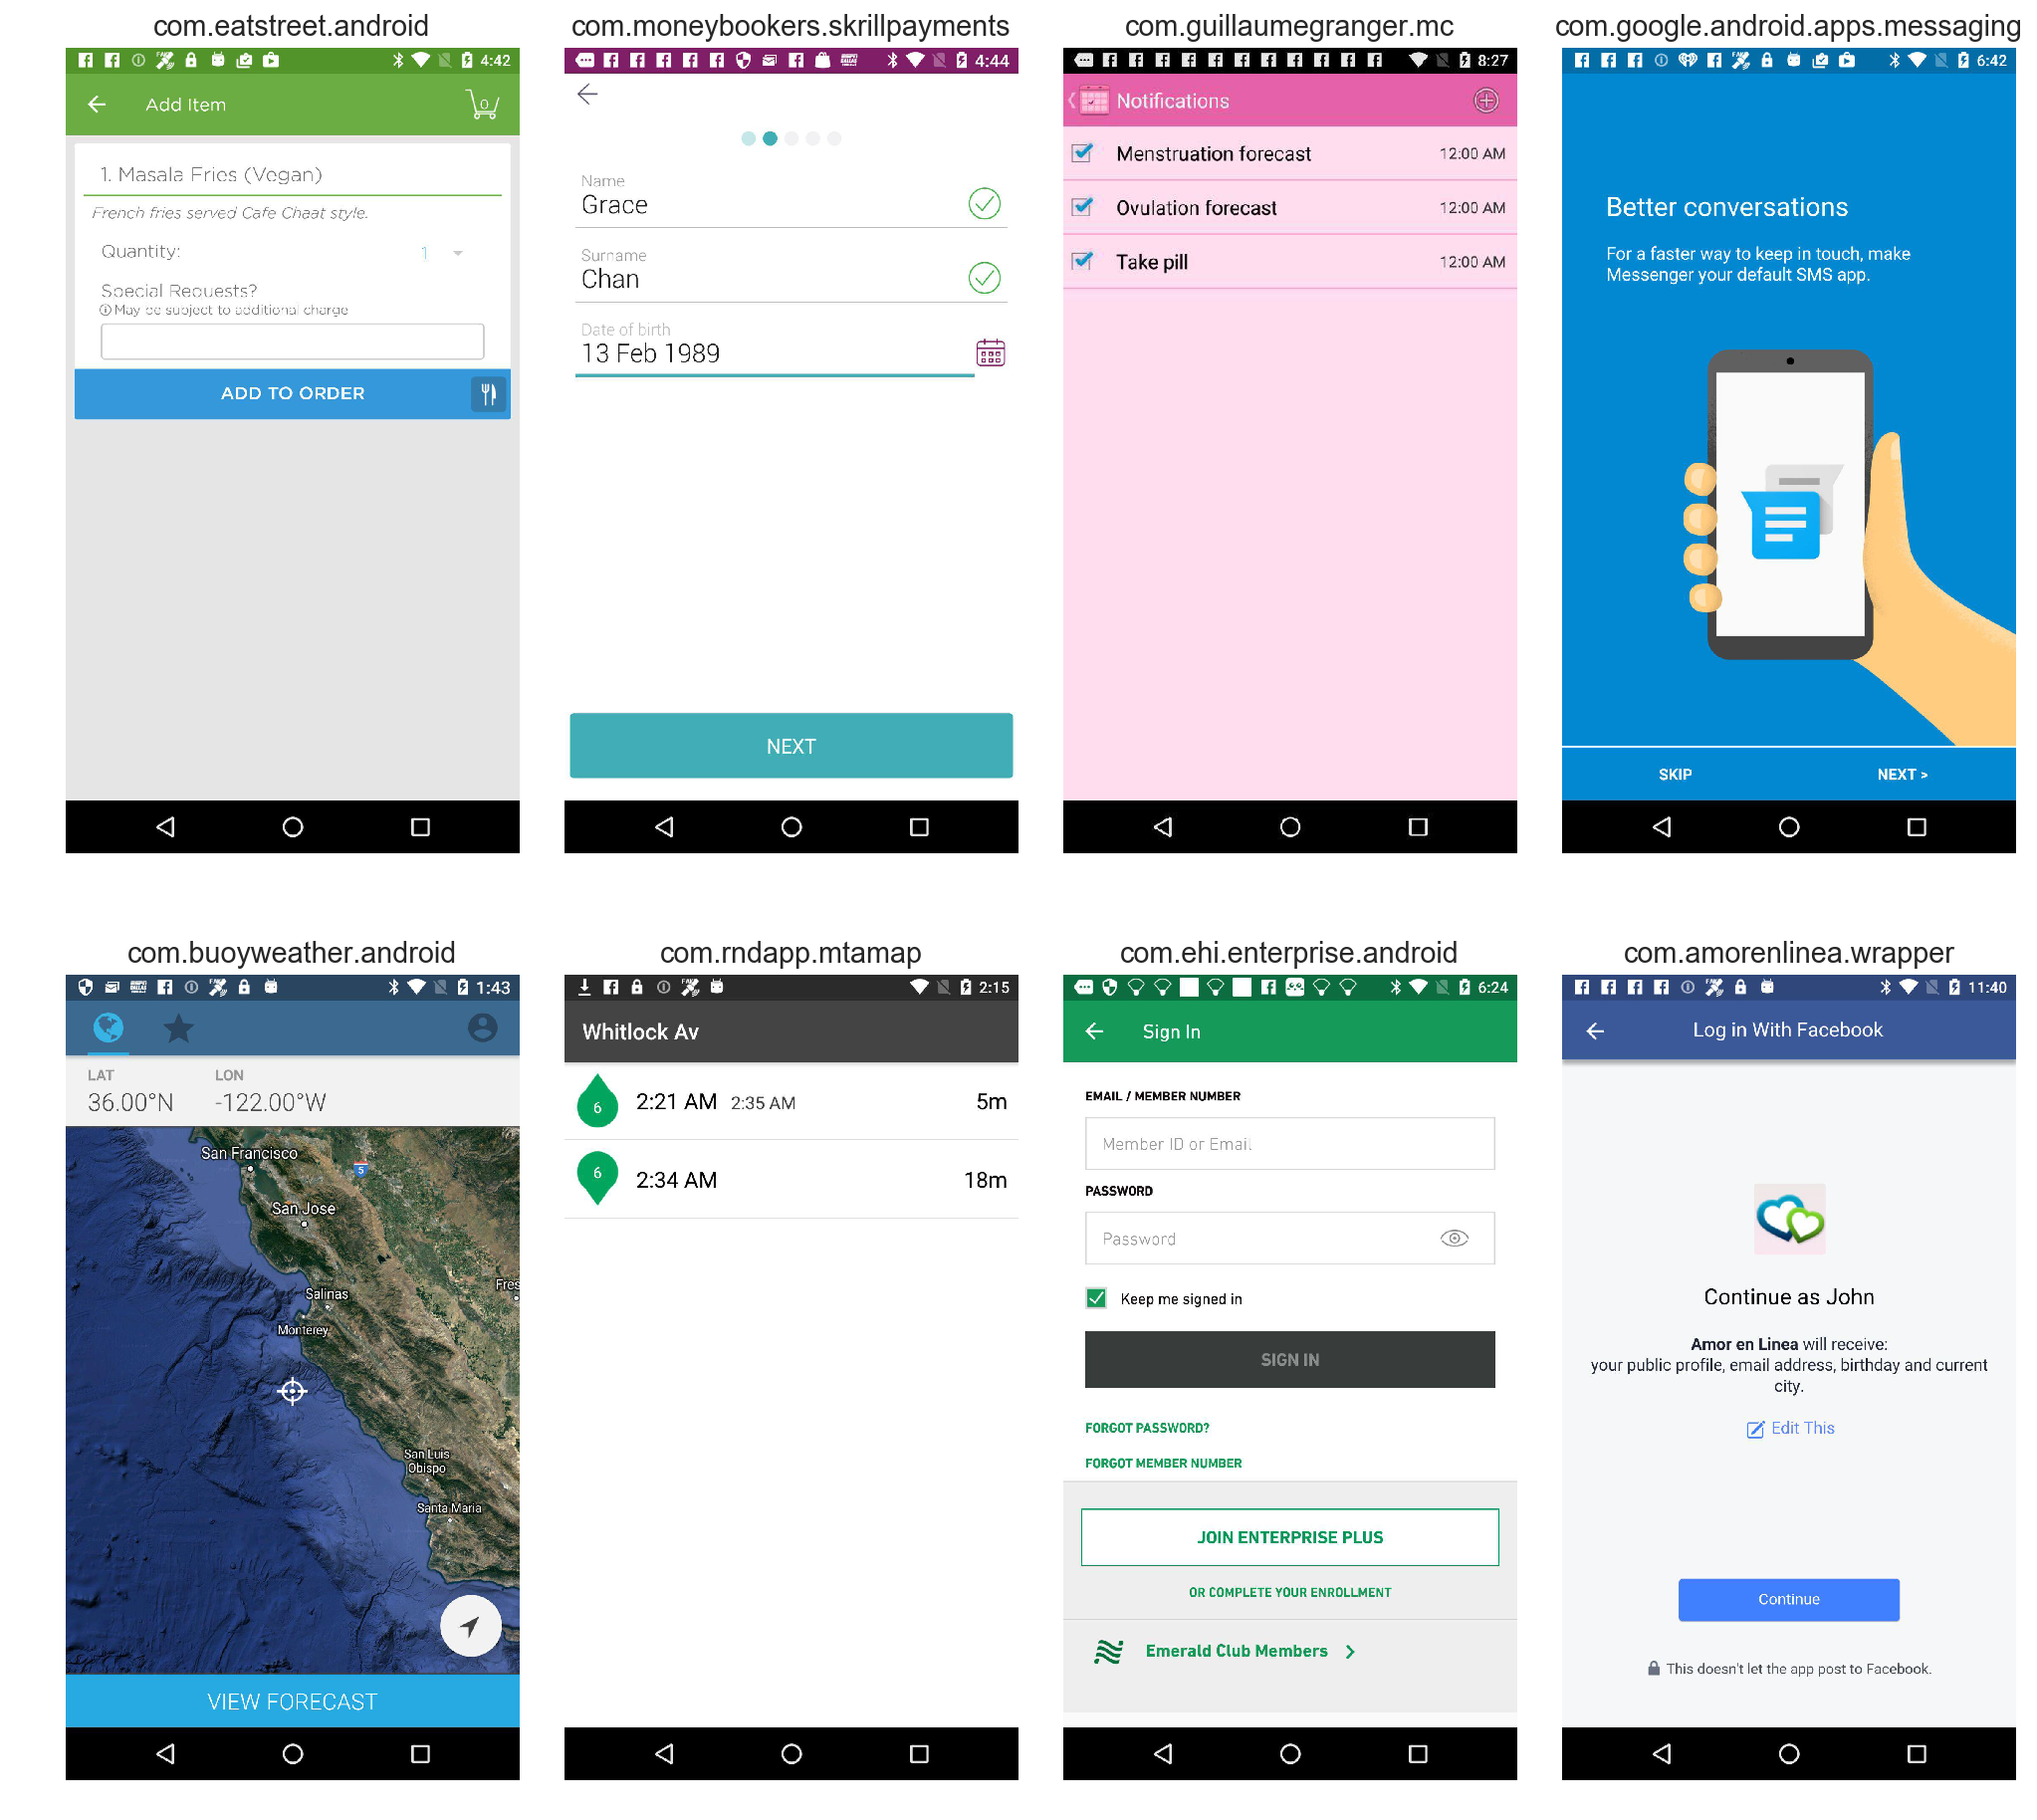

In [16]:
plt.rcParams['figure.figsize'] = (16.0, 16.0)
plt.subplots_adjust(wspace=0, hspace=0.15)

random_idx = ui_details_clean.sample(n=8, replace=False).index.values
for i, x in enumerate(random_idx):
    img = PIL.Image.open(ui_details_clean.filename[x])
    plt.subplot(2, 4, i + 1) 
    plt.imshow(img)
    plt.title(ui_details_clean.app_package_name[x])
    plt.axis('off');  

## App details: android play store metadata
Contains metadata about the apps in the dataset including an app’s category, average rating, number of ratings, and number of downloads. Unclear what "average rating" actually represents.

In [17]:
app_details = pd.read_csv('raw_data/app_details.csv')
app_details.reset_index(level=0, inplace=True)
app_details.rename(columns = {'index':'App Package Name',
                              'App Package Name':'app name',
                              'Category':'star rating',
                              'Play Store Name': 'app category'}, inplace = True)
app_details.columns = [c.lower().replace(' ', '_') for c in app_details.columns]
app_details.head()

,app_package_name,app_name,app_category,star_rating,average_rating,number_of_ratings,number_of_downloads
0,com.guideme.movieboxa,New Movie?Box Show Reference,Books & Reference,3.2,83,"10,000 - 50,000",NaN
1,com.aon.mangaareader,Mangaa Reader,Comics,4.0,686,"10,000 - 50,000",NaN
2,com.diaohs.cola,Eye Filter (Blue light filter),Health & Fitness,4.6,2606,"100,000 - 500,000",NaN
3,com.pinnatta.android.api.fbmess,Pinnatta for Messenger,Social,4.3,6724,"100,000 - 500,000",NaN
4,com.digidust.elokence.akinator.freemium,Akinator the Genie FREE,Entertainment,4.3,1171971,"50,000,000 - 100,000,000",NaN


In [18]:
app_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18814 entries, 0 to 18813
Data columns (total 7 columns):
app_package_name       18814 non-null object
app_name               18814 non-null object
app_category           18814 non-null object
star_rating            18814 non-null float64
average_rating         18814 non-null int64
number_of_ratings      18814 non-null object
number_of_downloads    0 non-null float64
dtypes: float64(2), int64(1), object(4)
memory usage: 1.0+ MB


#### Drop `number_of_downloads` as it contains no info

In [19]:
app_details.drop(['number_of_downloads'], axis=1, inplace=True)

#### Explore `app_package_names` and `app_name `

In [20]:
print('Shape: {0}'.format(app_details.shape))
print('Unique app names: {0:,}'.format(len(app_details.app_name.value_counts())))
print('Unique app packages: {0:,}'.format(len(app_details.app_package_name.value_counts())))
print('Num of ui_details.app_package_name equals app_details.app_package_name: \n{0}'.format(len(ui_details_clean.app_package_name.value_counts()) == len(app_details.app_package_name.value_counts())))

Shape: (18814, 6)
Unique app names: 11,062
Unique app packages: 10,954
Num of ui_details.app_package_name equals app_details.app_package_name: 
False


#### Some apps share app name but have a different app package name 
What this means: more general/utility type apps will often have generic names but are created by different developers.

In [21]:
app_details.app_name.value_counts().head()

Music Player                  20
Weather                       15
Spanish English Translator    14
????                          14
Messenger                     12
Name: app_name, dtype: int64

In [22]:
app_details[app_details.app_name == 'Music Player'].head()

,app_package_name,app_name,app_category,star_rating,average_rating,number_of_ratings
2689,music.search.player.mp3player.cut.music,Music Player,Music & Audio,4.2,76107,"5,000,000 - 10,000,000"
3951,com.jrtstudio.music,Music Player,Music & Audio,3.9,219762,"10,000,000 - 50,000,000"
5206,media.audioplayer.musicplayer,Music Player,Music & Audio,4.4,672634,"10,000,000 - 50,000,000"
6411,com.zentertain.music.player,Music Player,Music & Audio,4.3,33664,"1,000,000 - 5,000,000"
7511,com.fotoable.mp3.musicplayer,Music Player,Music & Audio,4.1,8415,"500,000 - 1,000,000"


#### Duplicate app package names
Appears as though app package names have duplicate entries, however they do differ on average rating.

In [23]:
app_details.app_package_name.value_counts().head()

ru.mw                             4
com.sirma.mobile.bible.android    4
com.glidetalk.glideapp            4
info.androidz.horoscope           4
com.google.android.play.games     4
Name: app_package_name, dtype: int64

In [24]:
app_details[app_details.app_package_name == 'air.com.A3dtuning.Tuning3D'].head()

,app_package_name,app_name,app_category,star_rating,average_rating,number_of_ratings
7867,air.com.A3dtuning.Tuning3D,3DTuning,Entertainment,4.2,155394,"5,000,000 - 10,000,000"
12799,air.com.A3dtuning.Tuning3D,3DTuning,Entertainment,4.2,155265,"5,000,000 - 10,000,000"
17901,air.com.A3dtuning.Tuning3D,3DTuning,Entertainment,4.2,165518,"5,000,000 - 10,000,000"
18789,air.com.A3dtuning.Tuning3D,3DTuning,Entertainment,4.2,155394,"5,000,000 - 10,000,000"


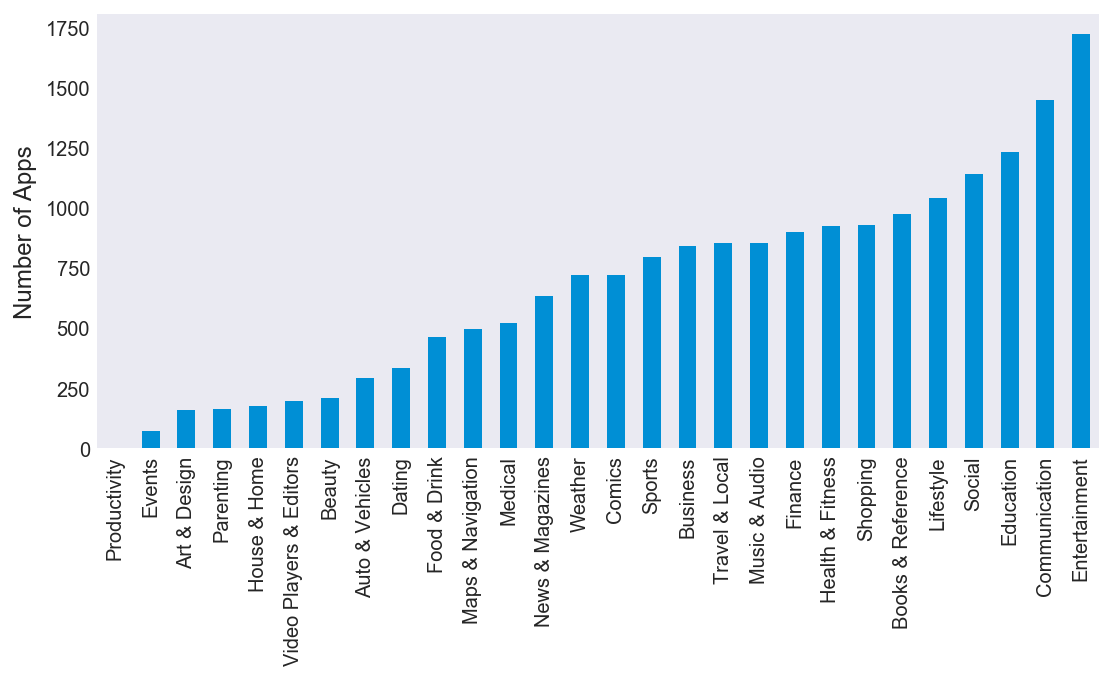

In [25]:
app_details.app_category.value_counts(ascending=True).plot.bar(figsize=(8,4)).set_ylabel('Number of Apps');

In [26]:
len(app_details.app_category.value_counts())

28

In [27]:
app_details[app_details.app_category == 'Productivity']

,app_package_name,app_name,app_category,star_rating,average_rating,number_of_ratings
18795,com.sftx.repost,Repost for Instagram RepostIt,Productivity,4.1,25836,"1,000,000 - 5,000,000"


In [28]:
app_details[app_details.app_category == 'Entertainment'].sort_values(by='star_rating', ascending=False).head()

,app_package_name,app_name,app_category,star_rating,average_rating,number_of_ratings
15352,com.crocusgames.destinyinventorymanager,Vault Item Manager for Destiny,Entertainment,4.8,1335,"10,000 - 50,000"
9220,com.jy.vplayer2,VSounds - Vine Soundboard Free,Entertainment,4.8,181790,"1,000,000 - 5,000,000"
11286,com.zpt.appgift,Cash Gift - Free Gift Cards,Entertainment,4.8,215295,"1,000,000 - 5,000,000"
18345,com.jy.vplayer2,VSounds - Vine Soundboard Free,Entertainment,4.8,181804,"1,000,000 - 5,000,000"
18119,com.zpt.appgift,Cash Gift - Free Gift Cards,Entertainment,4.8,215317,"1,000,000 - 5,000,000"


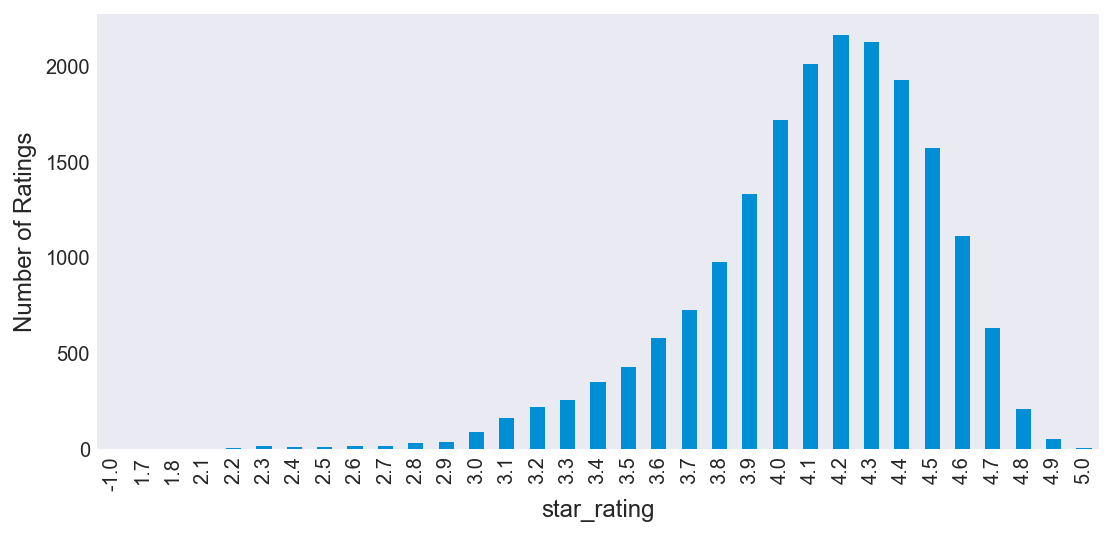

In [29]:
app_details.groupby('star_rating')['star_rating'].count().plot.bar(figsize=(8,4)).set_ylabel('Number of Ratings');

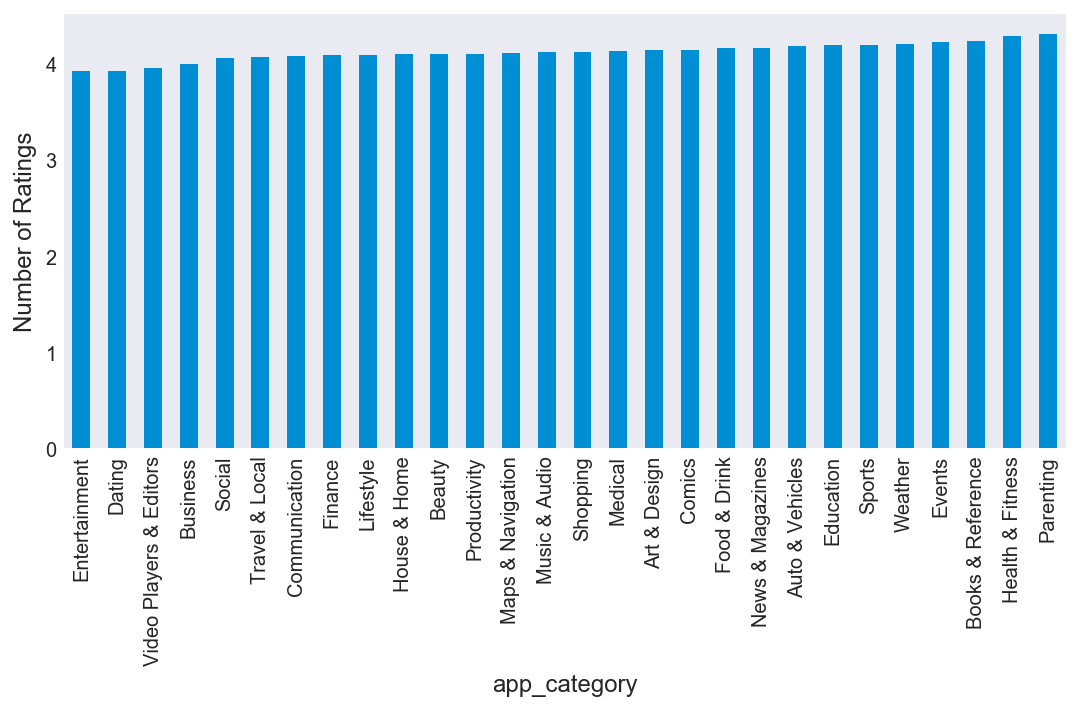

In [30]:
app_details.groupby('app_category')['star_rating'].mean().sort_values().plot.bar(figsize=(8,4)).set_ylabel('Number of Ratings');

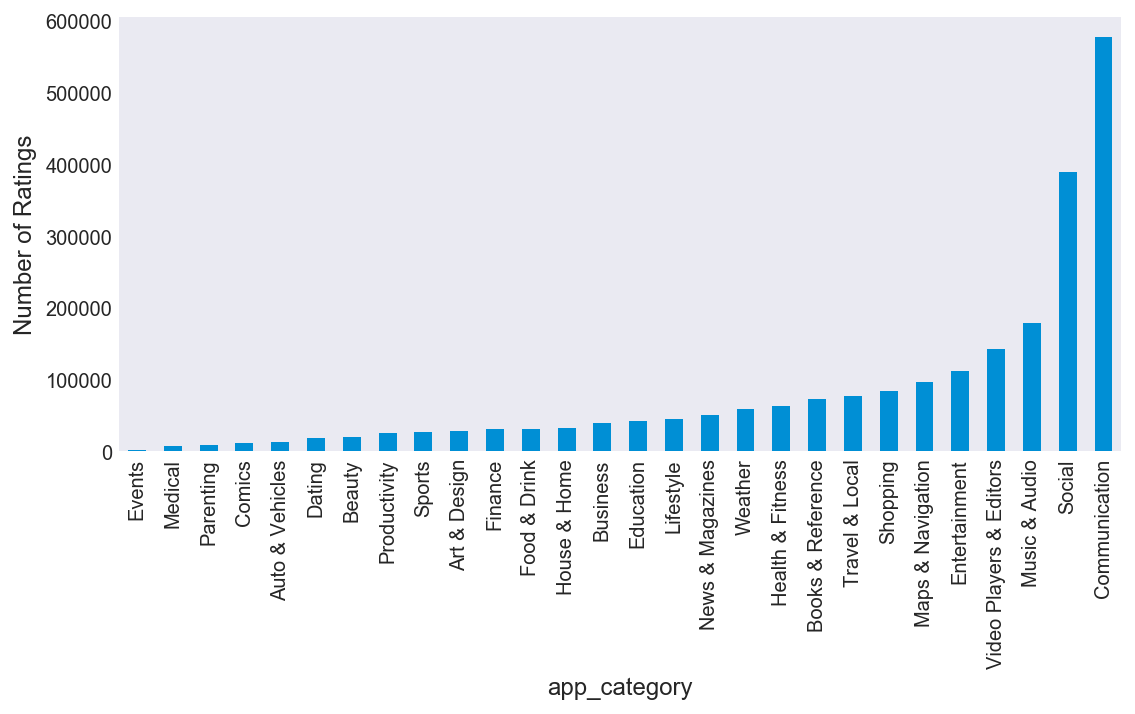

In [31]:
app_details.groupby('app_category')['average_rating'].mean().sort_values().plot.bar(figsize=(8,4)).set_ylabel('Number of Ratings');

In [32]:
app_details.groupby('app_category')['average_rating'].mean().head()

app_category
Art & Design         27937.335443
Auto & Vehicles      13553.356164
Beauty               20025.004785
Books & Reference    72607.655704
Business             40064.977461
Name: average_rating, dtype: float64

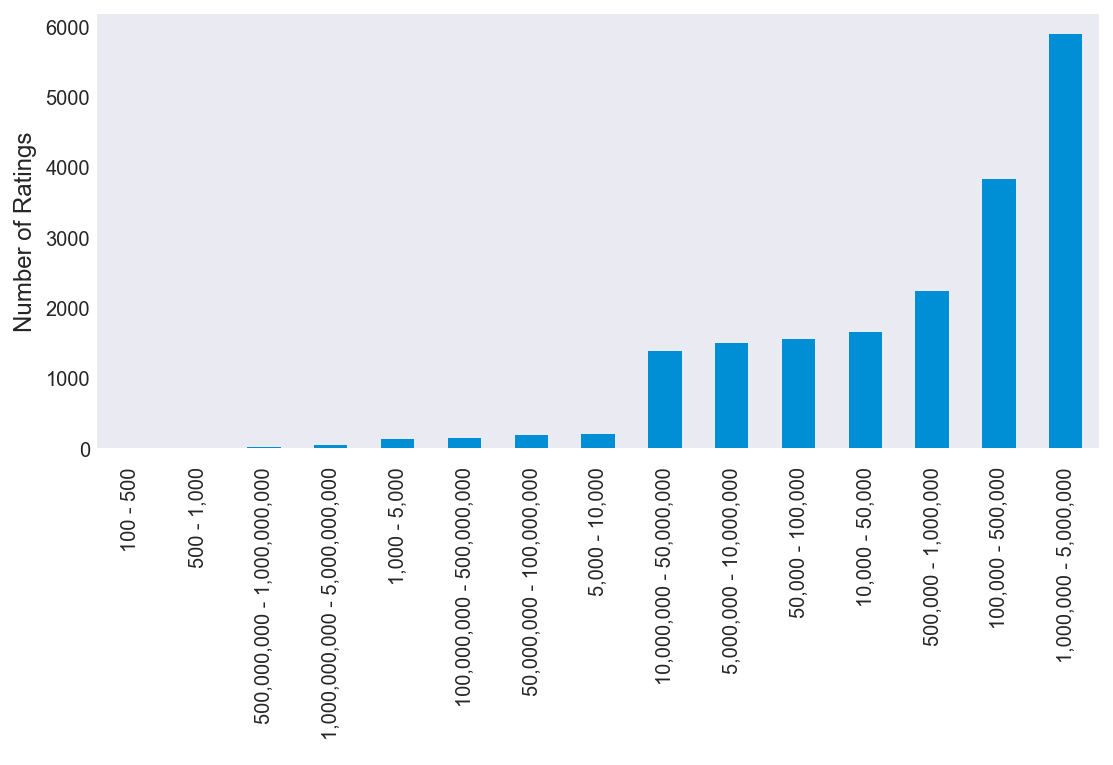

In [33]:
app_details.number_of_ratings.value_counts(ascending=True).plot.bar(figsize=(8,4)).set_ylabel('Number of Ratings');

In [34]:
app_details.number_of_ratings.value_counts()

  1,000,000 - 5,000,000              5887
  100,000 - 500,000                  3833
  500,000 - 1,000,000                2243
  10,000 - 50,000                    1653
  50,000 - 100,000                   1561
  5,000,000 - 10,000,000             1501
  10,000,000 - 50,000,000            1379
  5,000 - 10,000                      201
  50,000,000 - 100,000,000            194
  100,000,000 - 500,000,000           150
  1,000 - 5,000                       132
  1,000,000,000 - 5,000,000,000        49
  500,000,000 - 1,000,000,000          18
  500 - 1,000                           7
  100 - 500                             6
Name: number_of_ratings, dtype: int64

#### Drop rows with 5,000 or less ratings

In [35]:
def min_ratings(x):
    new_str = x.replace(',','').replace(' ','').replace('-',',')
    return min(list(map(int, new_str.split(','))))

In [36]:
app_details['min_ratings'] = app_details.number_of_ratings.map(lambda x: min_ratings(x))

In [37]:
app_details[app_details.min_ratings <= 5000].shape

(346, 7)

In [38]:
app_details.drop(app_details[app_details.min_ratings <= 5000].index, inplace=True)

In [39]:
app_details.shape

(18468, 7)

## Merge ui_details and app_details dataframes
#### Groupby `app_package_name` to generate dataframe of unique app packages from `ui_details` dataframe
Capture `ui_number`, `interaction_trace_number`, `ui_number_in_trace`, and `filename` in groupby.

In [40]:
d1 = {'ui_number': lambda x: list(set(x)),
     'interaction_trace_number': lambda x: list(set(x)),
     'ui_number_in_trace': lambda x: list(set(x)),
     'filename': lambda x: list(set(x))}


ui_details_agg = ui_details_clean.groupby('app_package_name').agg(d1)
ui_details_agg.reset_index(inplace=True)
ui_details_agg.head()

,app_package_name,ui_number,interaction_trace_number,ui_number_in_trace,filename
0,B4A.BigFivePersonalityTest,[49783],[0],[221],[app_uis/49783.jpg]
1,CN.MyPrivateMessages,[26083],[0],[15],[app_uis/26083.jpg]
2,DOCECG2.doctor,[51036],[0],[58],[app_uis/51036.jpg]
3,Gecko.Droid.PhysicsHelper,"[29868, 29869, 21237, 21238, 21239]","[0, 2]","[194, 269, 1361, 370, 285]","[app_uis/21237.jpg, app_uis/21239.jpg, app_uis..."
4,HinKhoj.Dictionary,"[42080, 42081, 42082, 42083, 42084, 42085, 420...",[1],"[864, 324, 741, 710, 132, 261, 876, 972, 654, ...","[app_uis/42074.jpg, app_uis/42075.jpg, app_uis..."


#### Again groupby `app_package_name` to generate dataframe of unique names in `app_details` dataframe
Capture app name, app category, star_rating, average_rating, and number of ratings as lists in groupby.

In [41]:
d2 = {'app_name': lambda x: list(set(x)),
     'app_category': lambda x: list(set(x)),
     'star_rating': lambda x: list(set(x)),
     'average_rating': lambda x: list(set(x)),
     'number_of_ratings': lambda x: list(set(x)),
     'min_ratings': lambda x: list(set(x))}


app_details_agg = app_details.groupby('app_package_name').agg(d2)
app_details_agg.reset_index(inplace=True)
app_details_agg.head()

,app_package_name,app_name,app_category,star_rating,average_rating,number_of_ratings,min_ratings
0,B4A.BigFivePersonalityTest,[Big 5 Personality Test],[Education],[3.6],[6698],"[ 1,000,000 - 5,000,000 ]",[1000000]
1,CN.MyPrivateMessages,[Calculator],[Communication],[4.3],"[17020, 16918, 16919]","[ 1,000,000 - 5,000,000 ]",[1000000]
2,Cam.SILENT,[Uva Silent Widget Camera Free],[Video Players & Editors],[3.9],[9616],"[ 5,000,000 - 10,000,000 ]",[5000000]
3,DOCECG2.doctor,[Electrocardiogram ECG Types],[Medical],[3.9],"[4134, 4135]","[ 500,000 - 1,000,000 ]",[500000]
4,Gecko.Droid.PhysicsHelper,[Pocket Physics],[Education],[4.1],[15938],"[ 1,000,000 - 5,000,000 ]",[1000000]


#### Find intersection of `app_package_name` for both dataframes

In [42]:
app_details_agg.app_package_name.shape, ui_details_agg.app_package_name.shape

((10806,), (9771,))

In [43]:
app_details_agg.app_package_name.isin(ui_details_agg.app_package_name).value_counts()

True     9620
False    1186
Name: app_package_name, dtype: int64

In [44]:
ui_details_agg.app_package_name.isin(app_details_agg.app_package_name).value_counts()

True     9620
False     151
Name: app_package_name, dtype: int64

Verify `isin` results

In [45]:
app_details_agg_lst = app_details_agg.app_package_name.values.tolist()
ui_details_agg_lst = ui_details_agg.app_package_name.values.tolist()

print(len([i for i in app_details_agg_lst if i not in ui_details_agg_lst]))
print(len([i for i in ui_details_agg_lst if i not in app_details_agg_lst]))

print(len(set(app_details_agg_lst).intersection(ui_details_agg_lst)))
print(len(set(ui_details_agg_lst).intersection(app_details_agg_lst)))

1186
151
9620
9620


#### Inner join both dataframes with `pd.merge`

In [46]:
app_ui_df = pd.merge(app_details_agg, ui_details_agg, on='app_package_name')
app_ui_df.head()

,app_package_name,app_name,app_category,star_rating,average_rating,number_of_ratings,min_ratings,ui_number,interaction_trace_number,ui_number_in_trace,filename
0,B4A.BigFivePersonalityTest,[Big 5 Personality Test],[Education],[3.6],[6698],"[ 1,000,000 - 5,000,000 ]",[1000000],[49783],[0],[221],[app_uis/49783.jpg]
1,CN.MyPrivateMessages,[Calculator],[Communication],[4.3],"[17020, 16918, 16919]","[ 1,000,000 - 5,000,000 ]",[1000000],[26083],[0],[15],[app_uis/26083.jpg]
2,DOCECG2.doctor,[Electrocardiogram ECG Types],[Medical],[3.9],"[4134, 4135]","[ 500,000 - 1,000,000 ]",[500000],[51036],[0],[58],[app_uis/51036.jpg]
3,Gecko.Droid.PhysicsHelper,[Pocket Physics],[Education],[4.1],[15938],"[ 1,000,000 - 5,000,000 ]",[1000000],"[29868, 29869, 21237, 21238, 21239]","[0, 2]","[194, 269, 1361, 370, 285]","[app_uis/21237.jpg, app_uis/21239.jpg, app_uis..."
4,HinKhoj.Dictionary,[English Hindi Dictionary],[Books & Reference],[4.3],"[246778, 247420]","[ 10,000,000 - 50,000,000 ]",[10000000],"[42080, 42081, 42082, 42083, 42084, 42085, 420...",[1],"[864, 324, 741, 710, 132, 261, 876, 972, 654, ...","[app_uis/42074.jpg, app_uis/42075.jpg, app_uis..."


In [47]:
print(app_ui_df.shape)

(9620, 11)


## Explore multiple listings from merge

#### Multiple app names 

In [48]:
app_ui_df['app_name_num'] = app_ui_df.app_name.map(lambda x: len(x))

In [49]:
app_ui_df.app_name_num.value_counts()

1    9290
2     330
Name: app_name_num, dtype: int64

In [50]:
app_ui_df[app_ui_df.app_name_num > 1].head()

,app_package_name,app_name,app_category,star_rating,average_rating,number_of_ratings,min_ratings,ui_number,interaction_trace_number,ui_number_in_trace,filename,app_name_num
20,air.Chat.org,"[Video Chat Rooms - Look2cam, Video Chat Rooms]",[Social],[4.0],"[16824, 16116]","[ 1,000,000 - 5,000,000 ]",[1000000],[20513],[2],[15],[app_uis/20513.jpg],2
51,air.com.flaxbin.chat,"[ChatVideo - Free Video Chat, ChatVideo ? Meet...",[Dating],[4.1],"[37440, 44854]","[ 1,000,000 - 5,000,000 ]",[1000000],"[69434, 69435, 69436]",[0],"[130, 334, 1543]","[app_uis/69434.jpg, app_uis/69436.jpg, app_uis...",2
95,air.net.thedigitalsits.molfar.prankcalldial,"[Prankster - the Prank Call App, Prankster - P...",[Entertainment],"[4.4, 4.3]","[23516, 11868]","[ 100,000 - 500,000 , 500,000 - 1,000,000 ]","[100000, 500000]","[30017, 30018]",[0],"[62, 63]","[app_uis/30018.jpg, app_uis/30017.jpg]",2
121,and.p2l,"[Phone 2 Location - Caller Id, Mobile Phone Nu...",[Communication],[4.1],"[83320, 83338, 83339, 83949]","[ 5,000,000 - 10,000,000 ]",[5000000],[12294],[0],[101],[app_uis/12294.jpg],2
142,app.hurdlr.com,"[Hurdlr for Drivers, Hurdlr - 1099 Taxes & Mil...",[Business],"[4.7, 4.6]","[1121, 1515]","[ 50,000 - 100,000 ]",[50000],"[506, 507, 508, 509]",[0],"[505, 331, 611, 305]","[app_uis/506.jpg, app_uis/507.jpg, app_uis/509...",2


#### Multiple app categories 

In [51]:
app_ui_df['app_cat_num'] = app_ui_df.app_category.map(lambda x: len(x))

In [52]:
app_ui_df.app_cat_num.value_counts()

1    9567
2      53
Name: app_cat_num, dtype: int64

In [53]:
app_ui_df[app_ui_df.app_cat_num > 1].head()

,app_package_name,app_name,app_category,star_rating,average_rating,number_of_ratings,min_ratings,ui_number,interaction_trace_number,ui_number_in_trace,filename,app_name_num,app_cat_num
321,co.bikecomputer,[Bike Computer],"[Health & Fitness, Sports]","[4.6, 4.5]","[2121, 340]","[ 100,000 - 500,000 , 10,000 - 50,000 ]","[10000, 100000]","[9475, 9476, 9477, 9478, 9479, 9480]",[0],"[69, 17, 116, 125, 61, 30]","[app_uis/9478.jpg, app_uis/9480.jpg, app_uis/9...",1,2
327,co.clover.clover,[Clover Dating App],"[Dating, Social]","[4.1, 4.0]","[3442, 5743]","[ 100,000 - 500,000 ]",[100000],"[55475, 55476, 55477, 55478, 55479]",[0],"[429, 118, 1174, 854, 825]","[app_uis/55475.jpg, app_uis/55479.jpg, app_uis...",1,2
663,com.affinity.dallas_football,[Dallas Football Louder Rewards],"[Social, Sports]",[4.5],"[6952, 7739]","[ 100,000 - 500,000 ]",[100000],"[64424, 60945]","[1, 2]","[72, 287]","[app_uis/64424.jpg, app_uis/60945.jpg]",1,2
665,com.affinity.pittsburgh_football,[Pittsburgh Football Rewards],"[Social, Sports]",[4.4],"[3537, 3876]","[ 100,000 - 500,000 ]",[100000],"[24586, 61135]","[0, 2]","[2, 127]","[app_uis/24586.jpg, app_uis/61135.jpg]",1,2
797,com.amrelmadah.freelancing.zawagalan,[Marriage Mediator],"[Dating, Social]","[4.0, 4.1]","[622, 350]","[ 100,000 - 500,000 , 50,000 - 100,000 ]","[50000, 100000]","[11136, 11137, 11138, 11139, 11140, 11141, 111...",[0],"[1152, 900, 1191, 775, 1193, 656, 1265, 1234, ...","[app_uis/11145.jpg, app_uis/11143.jpg, app_uis...",1,2


#### Multiple app names AND categories 

In [54]:
print(app_ui_df[(app_ui_df.app_name_num > 1) & (app_ui_df.app_cat_num > 1)].shape)
app_ui_df[(app_ui_df.app_name_num > 1) & (app_ui_df.app_cat_num > 1)].head() 

(8, 13)


,app_package_name,app_name,app_category,star_rating,average_rating,number_of_ratings,min_ratings,ui_number,interaction_trace_number,ui_number_in_trace,filename,app_name_num,app_cat_num
1839,com.cliqs.love.romance.sms,"[5000+ Love Messages SMS, 5000+ Love Messages ...","[Social, Communication]",[4.2],"[20112, 19325]","[ 1,000,000 - 5,000,000 ]",[1000000],"[451, 452, 453]",[0],"[26, 204, 62]","[app_uis/451.jpg, app_uis/452.jpg, app_uis/453...",2,2
2795,com.fitradio,"[FitRadio Workout Music & Coach, FIT Radio Wor...","[Health & Fitness, Music & Audio]",[4.2],"[10519, 10167]","[ 1,000,000 - 5,000,000 , 500,000 - 1,000,...","[500000, 1000000]","[38433, 38434, 38435, 38436, 38437, 38438, 384...",[0],"[3, 132, 807, 811, 172, 141, 12, 786, 53, 822,...","[app_uis/38438.jpg, app_uis/38436.jpg, app_uis...",2,2
3666,com.ilocatemobile.track,"[Track Any Phone -ilocateMobile, Track Any Pho...","[Social, Lifestyle]",[3.7],"[9281, 7889, 7871]","[ 1,000,000 - 5,000,000 ]",[1000000],[19900],[0],[1235],[app_uis/19900.jpg],2,2
3681,com.imp.hoorray,"[MyGreatRecipes, My Great Recipes]","[Food & Drink, Lifestyle]",[4.4],"[389, 318]","[ 50,000 - 100,000 ]",[50000],"[69416, 69417, 69415]",[0],"[107, 94, 22]","[app_uis/69415.jpg, app_uis/69417.jpg, app_uis...",2,2
3687,com.inapp.incolor,"[Incolor - Coloring Book, InColor - Coloring B...","[Entertainment, Art & Design]","[4.4, 4.6]","[16894, 2231]","[ 100,000 - 500,000 , 500,000 - 1,000,000 ]","[100000, 500000]","[61152, 61153, 61154, 61155, 61156, 61157, 611...",[0],"[512, 513, 66, 196, 165, 5, 37, 73, 12, 142, 1...","[app_uis/61146.jpg, app_uis/61153.jpg, app_uis...",2,2


#### Drop rows with multiple app categories
To make things cleaner — only 53 rows

In [55]:
app_ui_df.drop(app_ui_df[app_ui_df.app_cat_num > 1].index, inplace=True)

In [56]:
app_ui_df.shape

(9567, 13)

In [57]:
app_ui_df['app_category'] = app_ui_df.app_category.map(lambda x: x[0])

#### Multiple star ratings

In [58]:
app_ui_df['star_rating_num'] = app_ui_df.star_rating.map(lambda x: len(x))

In [59]:
app_ui_df.star_rating_num.value_counts()

1    8259
2    1308
Name: star_rating_num, dtype: int64

In [60]:
app_ui_df[app_ui_df.star_rating_num > 1].head()

,app_package_name,app_name,app_category,star_rating,average_rating,number_of_ratings,min_ratings,ui_number,interaction_trace_number,ui_number_in_trace,filename,app_name_num,app_cat_num,star_rating_num
9,SavySoda.PrivateBrowsing,[Full Screen Private Browsing],Communication,"[3.8, 3.7]","[1537, 1495]","[ 100,000 - 500,000 ]",[100000],"[38944, 38945, 38946, 38947, 38948, 57785, 57786]","[0, 1]","[129, 3, 196, 138, 107, 177, 117]","[app_uis/38945.jpg, app_uis/38946.jpg, app_uis...",1,1,2
21,air.FootballDoodFree,[Football Dood],Sports,"[3.7, 3.8]","[1122, 1147]","[ 100,000 - 500,000 ]",[100000],"[46752, 46753, 46754]",[0],"[1, 189, 142]","[app_uis/46753.jpg, app_uis/46754.jpg, app_uis...",1,1,2
31,air.bahraniapps.comicspanelcreator,[Comics Panel Creator],Comics,"[3.5, 3.4]","[297, 253]","[ 10,000 - 50,000 ]",[10000],"[23192, 23190, 23191]",[0],"[768, 932, 432]","[app_uis/23192.jpg, app_uis/23190.jpg, app_uis...",1,1,2
36,air.cbn.superbook.bible.app.android,"[Superbook Bible, Video & Games]",Education,"[4.7, 4.8]","[72513, 60571]","[ 1,000,000 - 5,000,000 ]",[1000000],[57834],[0],[125],[app_uis/57834.jpg],1,1,2
39,air.com.KalromSystems.SandDrawLite,[Sand Draw Sketch: Drawing Pad],Art & Design,"[4.0, 4.2]","[45507, 33797, 33695]","[ 1,000,000 - 5,000,000 ]",[1000000],[50670],[0],[1640],[app_uis/50670.jpg],1,1,2


#### Multiple average ratings

In [61]:
app_ui_df['average_rating_num'] = app_ui_df.average_rating.map(lambda x: len(x))

In [62]:
app_ui_df.average_rating_num.value_counts()

1    4823
2    3093
3    1432
4     219
Name: average_rating_num, dtype: int64

In [63]:
app_ui_df[app_ui_df.average_rating_num > 1].head()

,app_package_name,app_name,app_category,star_rating,average_rating,number_of_ratings,min_ratings,ui_number,interaction_trace_number,ui_number_in_trace,filename,app_name_num,app_cat_num,star_rating_num,average_rating_num
1,CN.MyPrivateMessages,[Calculator],Communication,[4.3],"[17020, 16918, 16919]","[ 1,000,000 - 5,000,000 ]",[1000000],[26083],[0],[15],[app_uis/26083.jpg],1,1,1,3
2,DOCECG2.doctor,[Electrocardiogram ECG Types],Medical,[3.9],"[4134, 4135]","[ 500,000 - 1,000,000 ]",[500000],[51036],[0],[58],[app_uis/51036.jpg],1,1,1,2
4,HinKhoj.Dictionary,[English Hindi Dictionary],Books & Reference,[4.3],"[246778, 247420]","[ 10,000,000 - 50,000,000 ]",[10000000],"[42080, 42081, 42082, 42083, 42084, 42085, 420...",[1],"[864, 324, 741, 710, 132, 261, 876, 972, 654, ...","[app_uis/42074.jpg, app_uis/42075.jpg, app_uis...",1,1,1,2
5,Kal.FlightInfo,[Korean Air],Travel & Local,[3.0],"[7049, 7083, 7145]","[ 1,000,000 - 5,000,000 ]",[1000000],"[57784, 57782, 57783]",[0],"[272, 2, 228]","[app_uis/57783.jpg, app_uis/57782.jpg, app_uis...",1,1,1,3
9,SavySoda.PrivateBrowsing,[Full Screen Private Browsing],Communication,"[3.8, 3.7]","[1537, 1495]","[ 100,000 - 500,000 ]",[100000],"[38944, 38945, 38946, 38947, 38948, 57785, 57786]","[0, 1]","[129, 3, 196, 138, 107, 177, 117]","[app_uis/38945.jpg, app_uis/38946.jpg, app_uis...",1,1,2,2


#### Multiple number of ratings 

In [64]:
app_ui_df['number_of_ratings_num'] = app_ui_df.number_of_ratings.map(lambda x: len(x))

In [65]:
app_ui_df.number_of_ratings_num.value_counts()

1    8685
2     882
Name: number_of_ratings_num, dtype: int64

In [66]:
app_ui_df[app_ui_df.number_of_ratings_num > 1].head()

,app_package_name,app_name,app_category,star_rating,average_rating,number_of_ratings,min_ratings,ui_number,interaction_trace_number,ui_number_in_trace,filename,app_name_num,app_cat_num,star_rating_num,average_rating_num,number_of_ratings_num
41,air.com.animangaplus.johnnytest01,[Johnny Test: Johnny X],Comics,[4.1],"[357, 486]","[ 10,000 - 50,000 , 50,000 - 100,000 ]","[10000, 50000]",[17298],[0],[14],[app_uis/17298.jpg],1,1,1,2,2
43,air.com.animangaplus.totallyspies01,[Totally Spies!],Comics,[4.0],"[2235, 1919]","[ 100,000 - 500,000 , 50,000 - 100,000 ]","[50000, 100000]",[41239],[0],[9],[app_uis/41239.jpg],1,1,1,2,2
47,air.com.designersofcode.lovecraftcollectionvol1,[Lovecraft Collection ? Vol. 1],Comics,[4.8],"[3596, 7870]","[ 100,000 - 500,000 , 10,000 - 50,000 ]","[10000, 100000]","[18915, 18916]",[0],"[3474, 3]","[app_uis/18915.jpg, app_uis/18916.jpg]",1,1,1,2,2
71,air.com.nbcuni.com.telemundo.envivo,[Telemundo Deportes - En Vivo],Sports,"[4.2, 4.3]","[4889, 5003]","[ 100,000 - 500,000 , 500,000 - 1,000,000 ]","[100000, 500000]","[64041, 70349, 70350, 70351, 70352, 70353]","[0, 1]","[1216, 740, 710, 6, 211, 446]","[app_uis/70350.jpg, app_uis/70352.jpg, app_uis...",1,1,2,2,2
95,air.net.thedigitalsits.molfar.prankcalldial,"[Prankster - the Prank Call App, Prankster - P...",Entertainment,"[4.4, 4.3]","[23516, 11868]","[ 100,000 - 500,000 , 500,000 - 1,000,000 ]","[100000, 500000]","[30017, 30018]",[0],"[62, 63]","[app_uis/30018.jpg, app_uis/30017.jpg]",2,1,2,2,2


#### Multiple filename

In [67]:
app_ui_df['filename_num'] = app_ui_df.filename.map(lambda x: len(x))

In [68]:
app_ui_df.filename_num.value_counts().head()

1    1397
2    1153
3     997
4     872
5     697
Name: filename_num, dtype: int64

In [69]:
app_ui_df[app_ui_df.filename_num > 1].head()

,app_package_name,app_name,app_category,star_rating,average_rating,number_of_ratings,min_ratings,ui_number,interaction_trace_number,ui_number_in_trace,filename,app_name_num,app_cat_num,star_rating_num,average_rating_num,number_of_ratings_num,filename_num
3,Gecko.Droid.PhysicsHelper,[Pocket Physics],Education,[4.1],[15938],"[ 1,000,000 - 5,000,000 ]",[1000000],"[29868, 29869, 21237, 21238, 21239]","[0, 2]","[194, 269, 1361, 370, 285]","[app_uis/21237.jpg, app_uis/21239.jpg, app_uis...",1,1,1,1,1,5
4,HinKhoj.Dictionary,[English Hindi Dictionary],Books & Reference,[4.3],"[246778, 247420]","[ 10,000,000 - 50,000,000 ]",[10000000],"[42080, 42081, 42082, 42083, 42084, 42085, 420...",[1],"[864, 324, 741, 710, 132, 261, 876, 972, 654, ...","[app_uis/42074.jpg, app_uis/42075.jpg, app_uis...",1,1,1,2,1,20
5,Kal.FlightInfo,[Korean Air],Travel & Local,[3.0],"[7049, 7083, 7145]","[ 1,000,000 - 5,000,000 ]",[1000000],"[57784, 57782, 57783]",[0],"[272, 2, 228]","[app_uis/57783.jpg, app_uis/57782.jpg, app_uis...",1,1,1,3,1,3
6,Kenneth.Currency,[Currency],Finance,[4.2],[5174],"[ 1,000,000 - 5,000,000 ]",[1000000],"[51880, 51881, 51882, 51883, 51884, 51885]",[0],"[96, 129, 68, 202, 172, 270]","[app_uis/51885.jpg, app_uis/51880.jpg, app_uis...",1,1,1,1,1,6
7,Pawelz.Apps.Guns.Shot.Reload,[Guns - Shoot and Reload],Entertainment,[3.5],[5742],"[ 1,000,000 - 5,000,000 ]",[1000000],"[32512, 32513, 32514, 32508, 32509, 32510, 32511]",[0],"[64, 458, 42, 51, 84, 249, 284]","[app_uis/32509.jpg, app_uis/32513.jpg, app_uis...",1,1,1,1,1,7


#### Save resulting dataframe
Use df.to_pickle to prevent list data structure in dataframe being converted to a string encapsulated list.

In [70]:
app_ui_df.to_pickle('clean_data/app_ui_df.pkl')